<a href="https://colab.research.google.com/github/ditorizkyka/TA-Pothole-Detection-Computer-Vision/blob/main/TA_YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv11 Pothole Dectection (Baseline)

Bagian ini menjelaskan implementasi awal (baseline) model YOLOv11 untuk mendeteksi lubang jalan menggunakan parameter bawaan (default). Baseline digunakan sebagai acuan kinerja awal sebelum dilakukan proses optimasi dan perbandingan melalui hyperparameter tuning.

# Experimental Setup
Bagian ini menjelaskan lingkungan eksperimen yang digunakan dalam penelitian, meliputi platform komputasi, spesifikasi perangkat keras (GPU), framework dan library yang digunakan, serta konfigurasi umum pelatihan model. Experimental setup disusun untuk memastikan konsistensi, reprodusibilitas, dan keadilan evaluasi antar model dan skenario eksperimen.

In [ ]:
!nvidia-smi

!pip install ultralytics wandb


Fri Jan  2 16:13:53 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Collection(Pengumpulan Data)
Bagian ini menguraikan proses pengumpulan dataset yang digunakan dalam penelitian, termasuk sumber data, jumlah citra, serta karakteristik data seperti variasi kondisi pencahayaan dan lingkungan jalan. Dataset yang digunakan telah dianotasi dalam format YOLO dan disiapkan untuk mendukung proses pelatihan model deteksi objek.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0g1oLVsmKRymF1NXsqeU")
project = rf.workspace("arthana-dbw2b").project("pothole-detection-th8es")
version = project.version(9)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-detection-9 in yolov11:: 100%|██████████| 8474/8474 [00:01<00:00, 5497.78it/s]


# Data Splitting(Pembagian Data)
Bagian ini menjelaskan strategi pembagian dataset menjadi data latih (training), validasi (validation), dan pengujian (testing). Pembagian data dilakukan secara proporsional untuk memastikan bahwa model dapat dilatih secara optimal, dievaluasi secara objektif, serta diuji pada data yang tidak pernah dilihat sebelumnya.

In [ ]:
import os

for split in ["train","valid","test"]:
    img_dir = f"Pothole-detection-9/{split}/images"
    print(f"{split.upper()} → {len(os.listdir(img_dir))} gambar")

# Contoh daftar file train
os.listdir("Pothole-detection-9/train/images")[:5]


TRAIN → 3028 gambar
VALID → 670 gambar
TEST → 533 gambar


['IMG_1889_MOV-0827_jpg.rf.6688194511a9926486de0c7500771933.jpg',
 '20240223_125533_mp4-0443_jpg.rf.0f6e5b8d4c84eb00f2f6652e55ee75e8.jpg',
 '20240223_125533_mp4-0897_jpg.rf.113ad9393094a8901375170946a1e592.jpg',
 '20240223_124911_mp4-2293_jpg.rf.d4c8bd802721642750410034c9b9c006.jpg',
 '20240223_125533_mp4-1069_jpg.rf.0a2c668c7fa36b4e10868c666556f369.jpg']

In [ ]:
!cat Pothole-detection-9/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['Pothole-']

roboflow:
  workspace: arthana-dbw2b
  project: pothole-detection-th8es
  version: 9
  license: CC BY 4.0
  url: https://universe.roboflow.com/arthana-dbw2b/pothole-detection-th8es/dataset/9

# Model Training(Default Parameter/Baseline)
Bagian ini menjelaskan proses pelatihan model YOLOv11 menggunakan parameter default tanpa modifikasi khusus. Hasil dari tahap ini digunakan sebagai baseline performance yang mencerminkan kemampuan awal model sebelum dilakukan optimasi lebih lanjut melalui hyperparameter tuning.

In [ ]:
# --- BASELINE YOLOv11 EXPERIMENT ---
from ultralytics import YOLO
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load Model YOLOv11s (varian small → sesuai proposal)
model = YOLO("yolo11s.pt")
# model.model.model[-1].dropout = 0.2  # contoh inject dropout di head

# 2️⃣ Training Baseline (parameter default)
model.train(
    epochs= 80,
    data="Pothole-detection-9/data.yaml",  # dataset Roboflow yang sudah preprocessed
    project="pothole_exp",
    name="yolov11s_baseline",
)


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Pothole-detection-9/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11s_baseline2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f017990a390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Hyperparameter Tuning
Bagian ini membahas proses optimasi hyperparameter untuk meningkatkan performa model YOLOv11. Beberapa parameter utama seperti learning rate, batch size, jumlah epoch, dan optimizer disesuaikan secara bertahap untuk menemukan konfigurasi yang menghasilkan keseimbangan terbaik antara akurasi, stabilitas pelatihan, dan efisiensi komputasi.

In [ ]:
import ultralytics
from ultralytics import YOLO
import time
from pathlib import Path
import shutil

DATA = "Pothole-detection-9/data.yaml"

DRIVE_DIR = "/content/drive/MyDrive/09 LMS TELKOM UNIVERSITY/TAHUN 4/Download/00-TA/GRID SEARCH"
os.makedirs(DRIVE_DIR, exist_ok=True)
print(f"📁 Drive folder siap: {DRIVE_DIR}")

COMMON_ARGS = dict(
    optimizer="AdamW",
    weight_decay=5e-4,   # <–– Didefinisikan di sini
    project="pothole_grid_adamw",
    seed=42,
    device=0
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
📁 Drive folder siap: /content/drive/MyDrive/09 LMS TELKOM UNIVERSITY/TAHUN 4/Download/00-TA/GRID SEARCH


# Tuning 1


In [ ]:
# === Kombinasi: BS=8, LR=0.0001, Epoch=80 ===
model = YOLO("yolo11s.pt")

start = time.time()

model.train(
    data=DATA,
    epochs=80,
    batch=8,
    lr0=0.0001,
    name="y11s_bs8_lr0001_ep80",
    **COMMON_ARGS
)


end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs8_lr0001_ep802")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Pothole-detection-9/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y11s_bs8_lr0001_ep802, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, pl

# Tuning 2

In [ ]:
# === Kombinasi 2: BS=8, LR=0.01, Epoch=80 ===
from ultralytics import YOLO
import time

model = YOLO("yolo11s.pt")

start = time.time()

results = model.train(
    data=DATA,
    epochs=80,
    batch=8,
    lr0=0.01,
    name="y11s_bs8_lr001_ep80",
    **COMMON_ARGS
)

end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs8_lr001_ep80")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")


Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Pothole-detection-9/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y11s_bs8_lr001_ep80, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=

# Tuning 3

In [ ]:
model = YOLO("yolo11s.pt")

start = time.time()

model.train(
    data=DATA,
    epochs=80,
    batch=16,
    lr0=0.01,
    name="y11s_bs16_lr001_ep80",
    **COMMON_ARGS
)

end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs16_lr001_ep80")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Pothole-detection-9/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y11s_bs16_lr001_ep80, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plot

# Tuning 4

In [ ]:
model = YOLO("yolo11s.pt")

start = time.time()

model.train(
    data=DATA,
    epochs=80,
    batch=16,
    lr0=0.0001,
    name="y11s_bs16_lr0001_ep80",
    **COMMON_ARGS
)

end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs16_lr0001_ep80")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")

Ultralytics 8.3.226 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Pothole-detection-9/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=y11s_bs16_lr0001_ep80, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, p

In [ ]:
model = YOLO("yolo11s.pt")

start = time.time()

model.train(
    data=DATA,
    epochs=80,
    batch=16,
    lr0=0.01,
    name="y11s_bs16_lr001_ep80",
    **COMMON_ARGS
)

end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs16_lr001_ep120")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")

In [ ]:
model = YOLO("yolo11s.pt")

start = time.time()

model.train(
    data=DATA,
    epochs=80,
    batch=16,
    lr0=0.0001,
    name="y11s_bs16_lr001_ep120",
    **COMMON_ARGS
)

end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs16_lr001_ep120")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")

In [ ]:
model = YOLO("yolo11s.pt")

start = time.time()

model.train(
    data=DATA,
    epochs=120,
    batch=8,
    lr0=0.01,
    name="y11s_bs16_lr001_ep120",
    **COMMON_ARGS
)

end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs16_lr001_ep120")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")

In [ ]:
model = YOLO("yolo11s.pt")

start = time.time()

model.train(
    data=DATA,
    epochs=120,
    batch=8,
    lr0=0.0001,
    name="y11s_bs16_lr001_ep120",
    **COMMON_ARGS
)

end = time.time()
train_time = end - start

# Path hasil training (lokal di Colab)
local_dir = Path("/content/pothole_grid_adamw/y11s_bs16_lr001_ep120")

# Path tujuan di Google Drive
drive_dest = Path(DRIVE_DIR) / local_dir.name

# Copy seluruh folder ke Google Drive
shutil.copytree(local_dir, drive_dest, dirs_exist_ok=True)

print(f"✅ Training selesai dalam {train_time/60:.2f} menit")
print(f"📂 Hasil disalin ke Google Drive: {drive_dest}")

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11s.pt")

# KOMBINASI 2
# model.train(
#     data="Pothole-detection-9/data.yaml",
#     epochs=70,
#     batch=8,
#     lr0=0.005,
#     momentum=0.9,
#     weight_decay=0.0007,
#     mosaic=0.5,
#     name="train_yolov11_combo2"
# )


model.train(
    data="Pothole-detection-9/data.yaml",  # path ke dataset pothole Roboflow kamu
    epochs=60,                # cukup untuk mencapai konvergensi awal
    batch=8,                  # kecil agar stabil di GPU T4
    lr0=0.006,                # learning rate sedikit lebih rendah untuk stabilitas
    momentum=0.92,            # menjaga kestabilan gradien
    weight_decay=0.0005,      # regularisasi standar YOLO
    mosaic=0.7,               # augmentasi sedang untuk variasi tanpa noise berlebih
    name="train_yolov11_combo1"
)


Ultralytics 8.3.218 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Pothole-detection-9/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.006, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.92, mosaic=0.7, multi_scale=False, name=train_yolov11_combo1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a85d4383740>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model Testing and Metrics Evaluation
Bagian ini menjelaskan proses pengujian akhir model menggunakan data uji (test set) yang tidak terlibat dalam proses pelatihan maupun validasi. Evaluasi kinerja model dilakukan menggunakan metrik standar deteksi objek, seperti Precision, Recall, mAP@0.5, mAP@0.5:0.95, serta waktu inferensi, untuk menilai tingkat akurasi, sensitivitas deteksi, dan kelayakan model dalam skenario real-time.

In [ ]:
# --- 🧪 TESTING & EVALUASI MODEL BASELINE (FIXED) ---
from ultralytics import YOLO
import time, glob, pandas as pd

# 1️⃣ Load model terbaik
# model = YOLO("Yolov11-Model/baseline-best.pt")
model = YOLO("/content/best.pt")

# 2️⃣ Hitung waktu inferensi total di test set
test_images = glob.glob("Pothole-detection-9/test/images/*")
start_time = time.time()
results_test = model.val(data="Pothole-detection-9/data.yaml", split="test")
total_time = time.time() - start_time
inference_time = total_time / len(test_images) if len(test_images) > 0 else 0

# 3️⃣ Ambil metrik evaluasi utama
metrics = results_test.results_dict
precision = metrics.get("metrics/precision(B)", 0)
recall = metrics.get("metrics/recall(B)", 0)
map50 = metrics.get("metrics/mAP50(B)", 0)
map5095 = metrics.get("metrics/mAP50-95(B)", 0)

print("\n📊 HASIL EVALUASI BASELINE (TEST SET):")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"mAP@0.5       : {map50:.4f}")
print(f"mAP@0.5:0.95  : {map5095:.4f}")
print(f"Inference Time: {inference_time:.4f} detik/gambar")

# 4️⃣ Simpan hasil metrik ke CSV
pd.DataFrame([{
    "Precision": precision,
    "Recall": recall,
    "mAP@0.5": map50,
    "mAP@0.5:0.95": map5095,
    "Inference Time (s/img)": inference_time
}]).to_csv("baseline_metrics.csv", index=False)

print("\n✅ Hasil evaluasi baseline berhasil disimpan ke 'baseline_metrics.csv'")


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1359.9±391.3 MB/s, size: 60.3 KB)
val: Scanning /content/Pothole-detection-9/test/labels.cache... 533 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 533/533 83.9Kit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 12, len(boxes) = 641. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 4.0it/s 8.6s
                   all        533        641      0.801      0.683      0.727      0.361
Speed: 1.9ms preprocess, 8.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect

# Result Analysis and Visualization
Bagian ini menyajikan analisis hasil eksperimen secara kuantitatif dan kualitatif, yang dilengkapi dengan visualisasi grafik dan contoh hasil deteksi. Visualisasi digunakan untuk memperlihatkan pola konvergensi selama pelatihan, perbandingan performa antar konfigurasi, serta kualitas bounding box yang dihasilkan model pada berbagai kondisi lingkungan jalan.

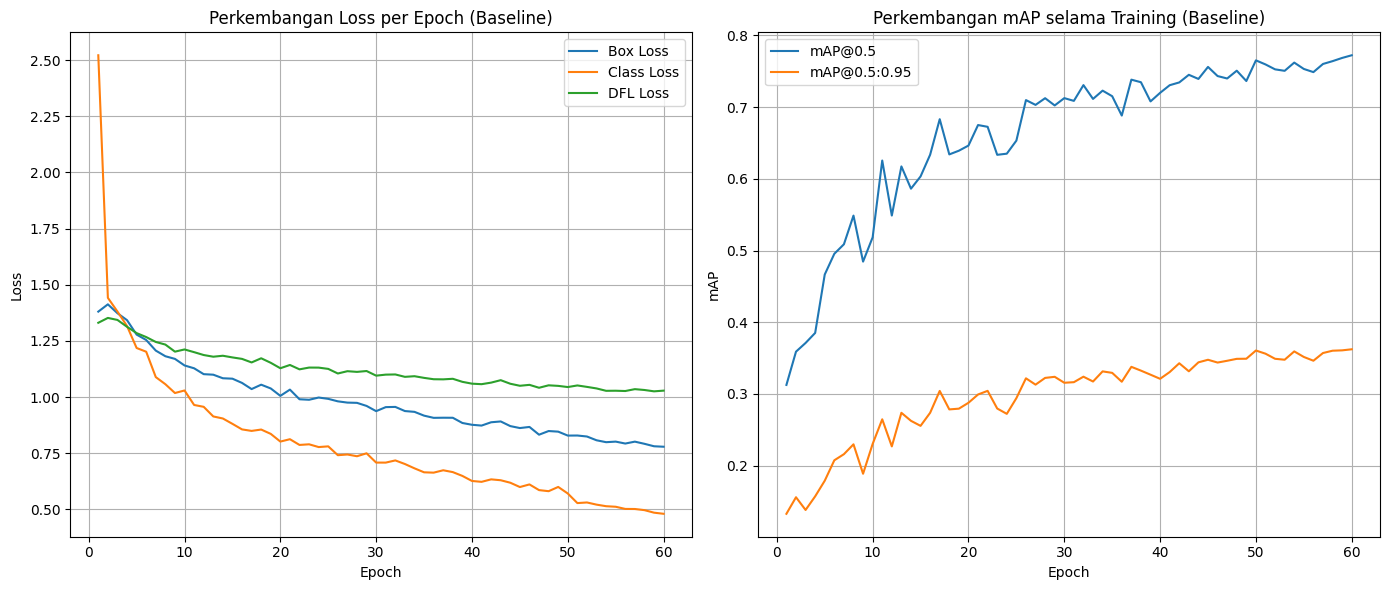

In [ ]:
# --- 📉 VISUALISASI HASIL TRAINING BASELINE ---
results_path = "runs/detect/train_yolov11_combo1/results.csv"
df = pd.read_csv(results_path)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="DFL Loss")
plt.title("Perkembangan Loss per Epoch (Baseline)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.title("Perkembangan mAP selama Training (Baseline)")
plt.xlabel("Epoch"); plt.ylabel("mAP"); plt.legend(); plt.grid()

plt.tight_layout()
plt.show()


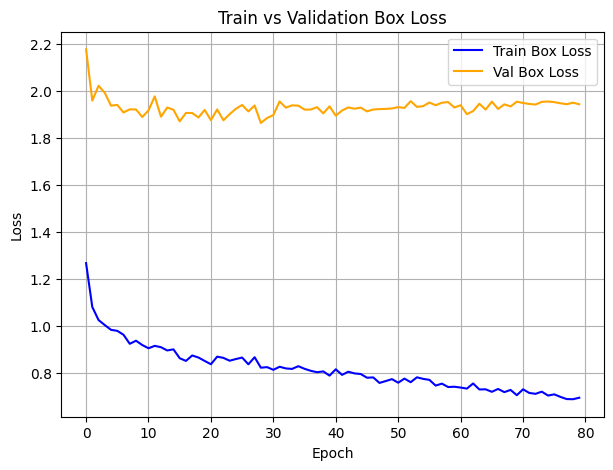

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ganti path ke folder hasil training kamu
results_path = "/content/pothole_grid_adamw/y11s_bs8_lr0001_ep802/results.csv"
df = pd.read_csv(results_path)

# Plot gabungan train vs val untuk box_loss
plt.figure(figsize=(7, 5))
plt.plot(df.index, df['train/box_loss'], label='Train Box Loss', color='blue')
plt.plot(df.index, df['val/box_loss'], label='Val Box Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Box Loss')
plt.legend()
plt.grid(True)
plt.show()


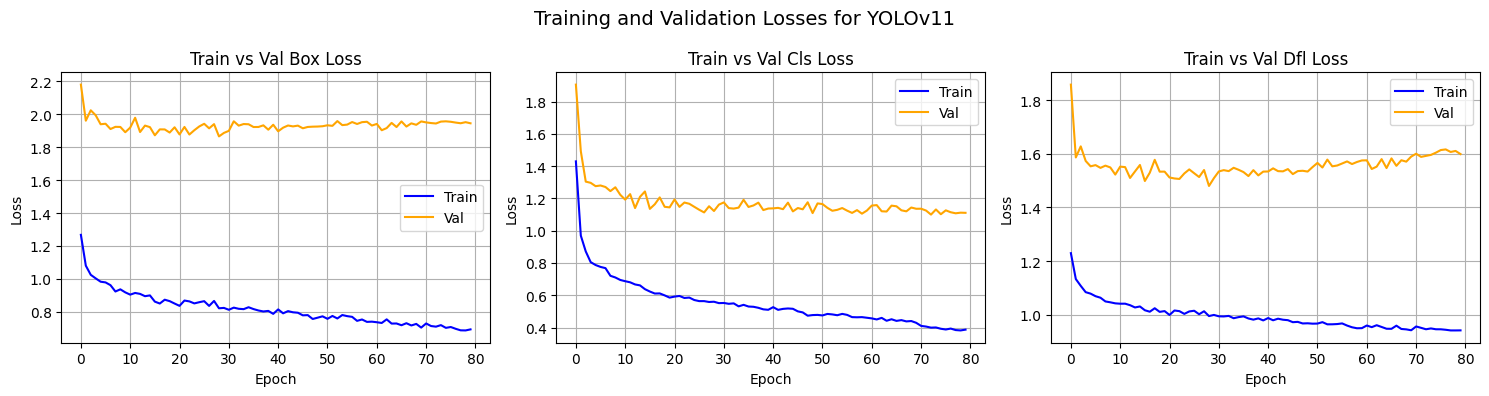

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Baca hasil training YOLOv11

plt.figure(figsize=(15,4))
losses = ['box_loss', 'cls_loss', 'dfl_loss']

for i, c in enumerate(losses):
    plt.subplot(1, 3, i+1)
    plt.plot(df.index, df[f'train/{c}'], label='Train', color='blue')
    plt.plot(df.index, df[f'val/{c}'], label='Val', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs Val {c.replace("_", " ").title()}')
    plt.legend()
    plt.grid(True)

plt.suptitle("Training and Validation Losses for YOLOv11", fontsize=14)
plt.tight_layout()
plt.show()


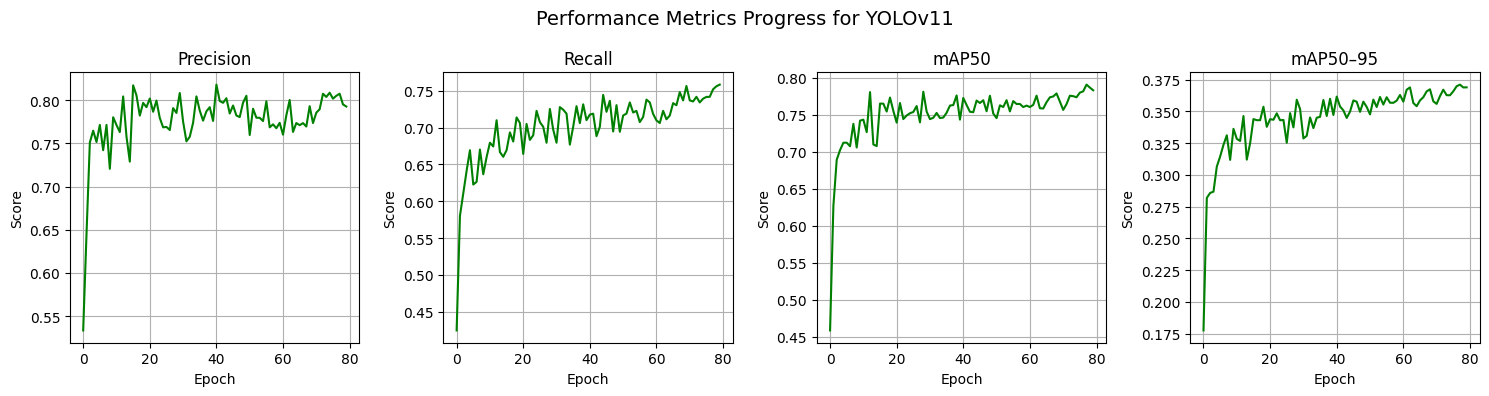

In [ ]:
plt.figure(figsize=(15,4))
metrics = ['metrics/precision(B)', 'metrics/recall(B)','metrics/mAP50(B)', 'metrics/mAP50-95(B)']
titles = ['Precision', 'Recall','mAP50', 'mAP50–95']

for i, m in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    plt.plot(df.index, df[m], color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(titles[i])
    plt.grid(True)

plt.tight_layout()
plt.show()


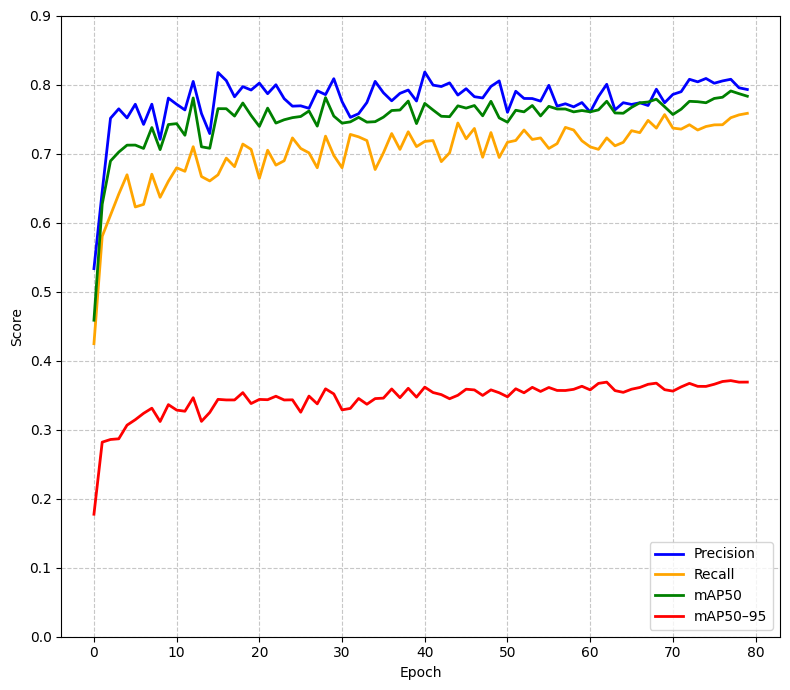

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Baca data hasil training YOLOv10
df = pd.read_csv("/content/pothole_grid_adamw/y11s_bs8_lr0001_ep802/results.csv")

plt.figure(figsize=(8,7))

# Plot metrik apa adanya (tanpa smoothing)
plt.plot(df.index, df['metrics/precision(B)'], label='Precision', color='blue', linewidth=2)
plt.plot(df.index, df['metrics/recall(B)'], label='Recall', color='orange', linewidth=2)
plt.plot(df.index, df['metrics/mAP50(B)'], label='mAP50', color='green', linewidth=2)
plt.plot(df.index, df['metrics/mAP50-95(B)'], label='mAP50–95', color='red', linewidth=2)

# Label dan tampilan
plt.xlabel('Epoch')
plt.ylabel('Score')
# plt.title('YOLOv10s Training Metrics Progress')
plt.ylim(0, 0.9)        # skala seragam biar apple-to-apple
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


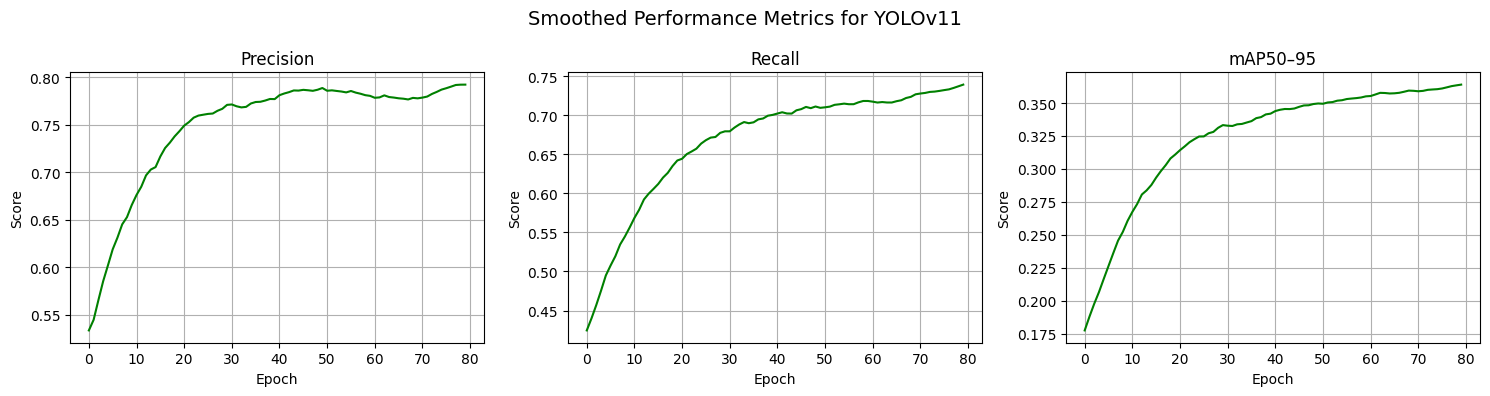

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def smooth_curve(values, weight=0.8):
    """Simple exponential moving average smoothing."""
    smoothed = []
    last = values[0]
    for v in values:
        smoothed_val = last * weight + (1 - weight) * v
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

plt.figure(figsize=(15,4))
metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50-95(B)']
titles = ['Precision', 'Recall', 'mAP50–95']

for i, m in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    y = smooth_curve(df[m].values, weight=0.9)  # makin besar weight → makin halus
    plt.plot(df.index, y, color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title(titles[i])
    plt.grid(True)

plt.suptitle("Smoothed Performance Metrics for YOLOv11", fontsize=14)
plt.tight_layout()
plt.show()


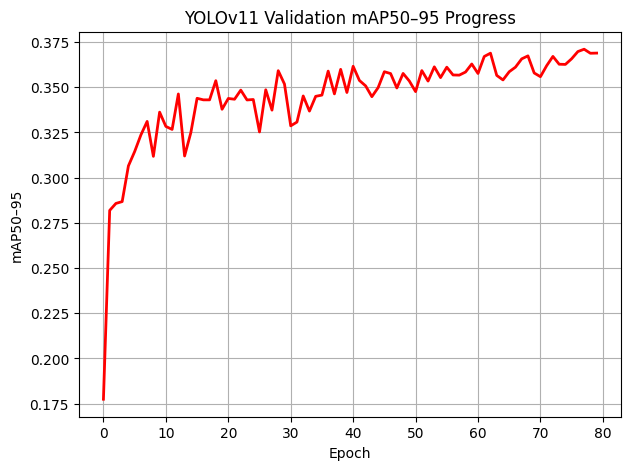

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(df.index, df['metrics/mAP50-95(B)'], color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('mAP50–95')
plt.title('YOLOv11 Validation mAP50–95 Progress')
plt.grid(True)
plt.show()


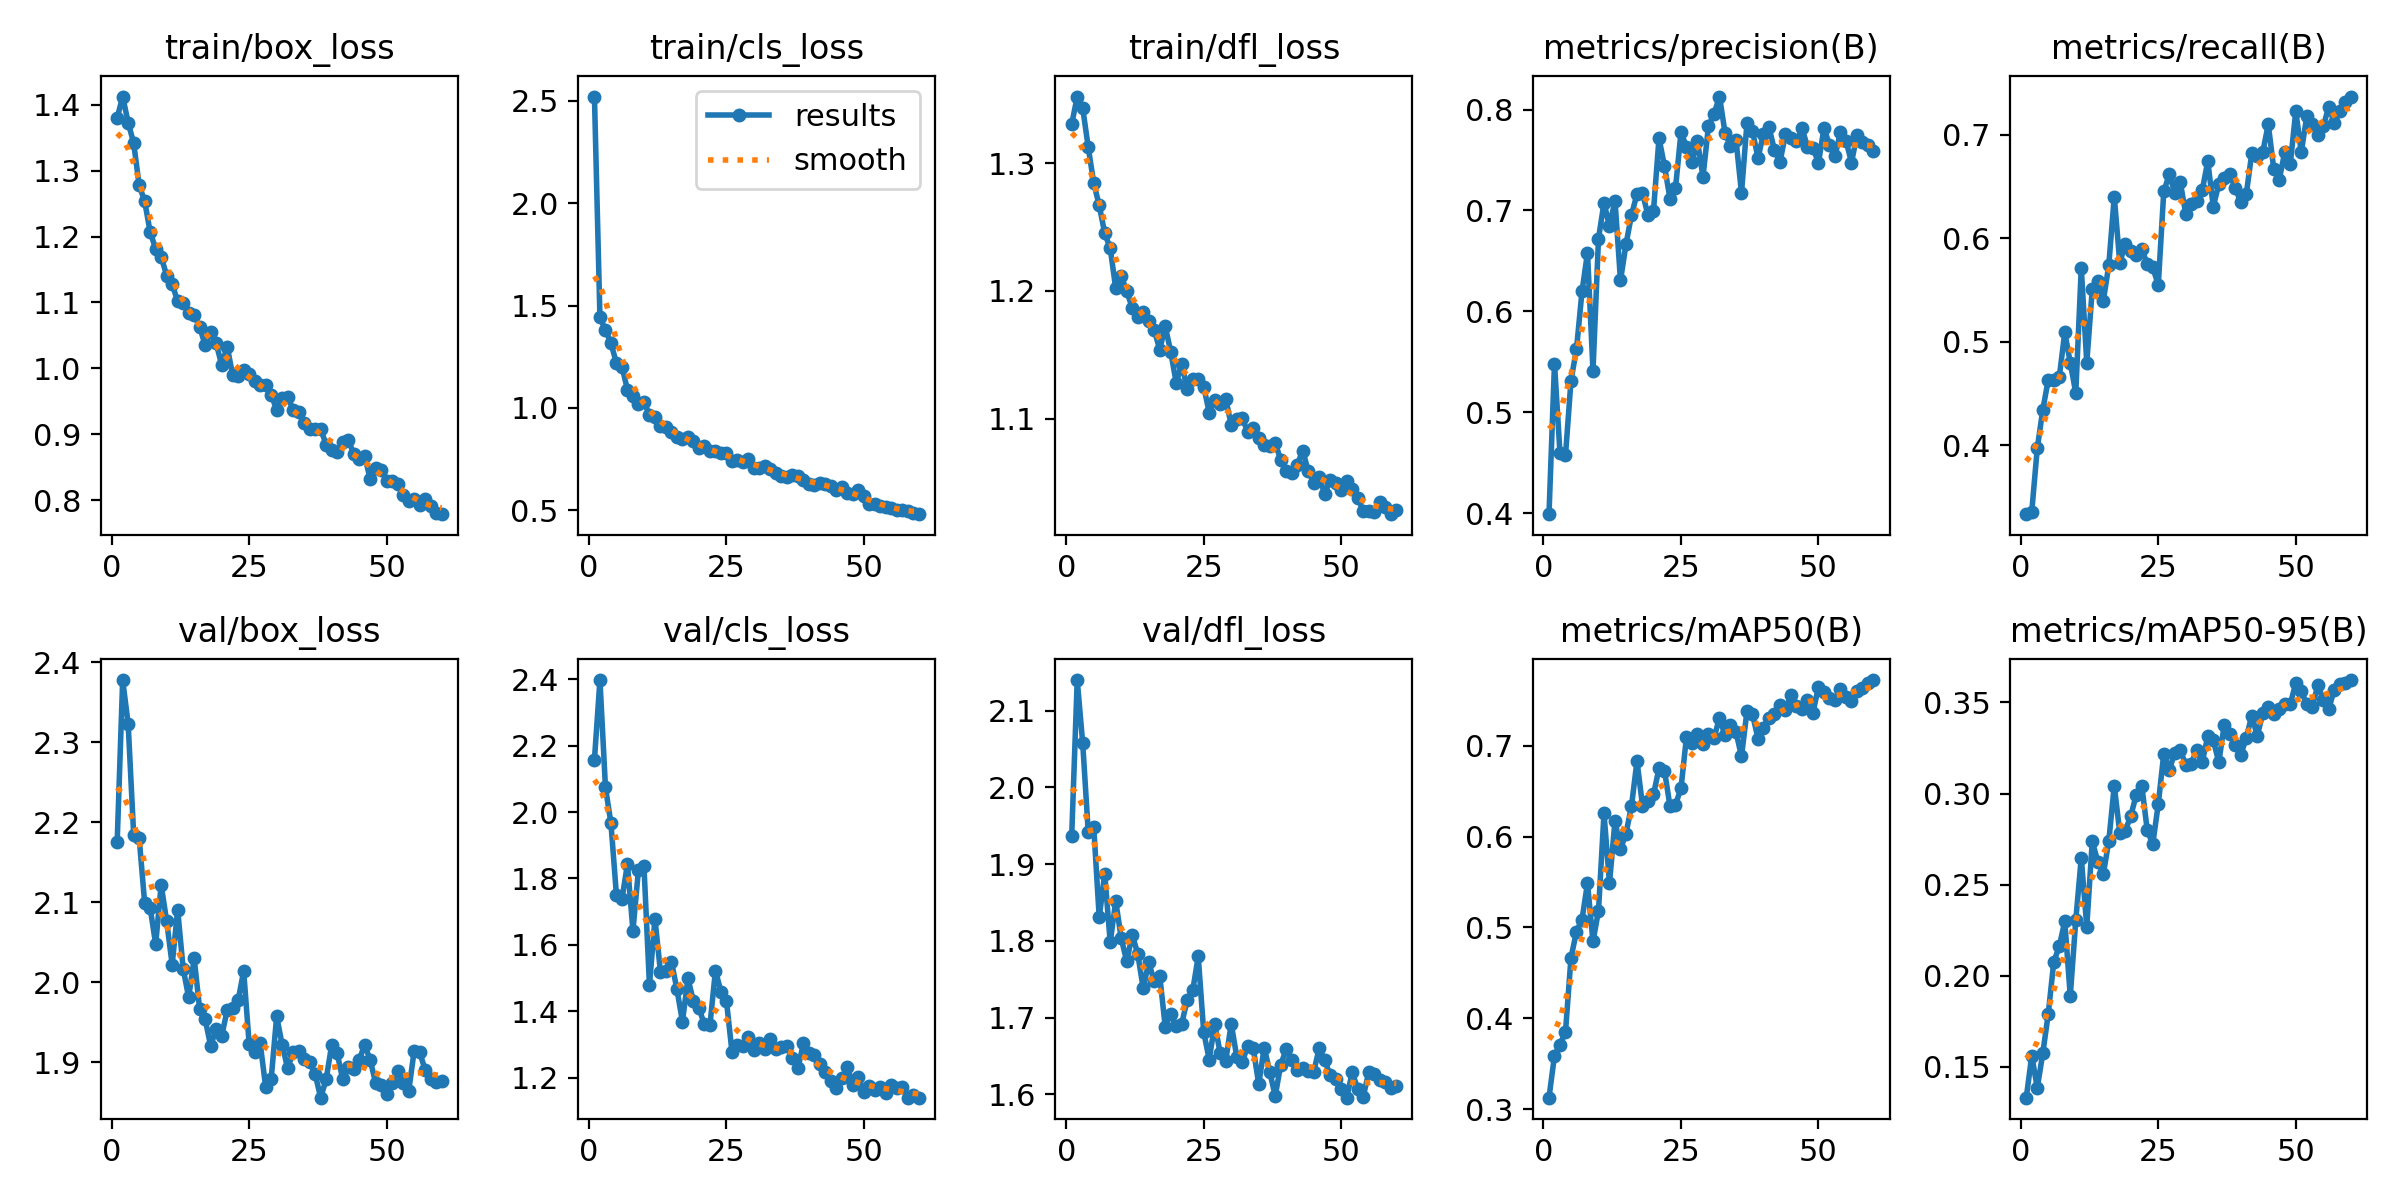

In [ ]:
from IPython.display import Image
Image(filename="runs/detect/train_yolov11_combo1/results.png")



image 1/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0000_jpg.rf.e62dd31f0fa7f17d98426589e78d9d92.jpg: 640x640 2 Pothole-s, 15.5ms
image 2/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0001_jpg.rf.25a333b82f7b18d7d42953d2d9e04b80.jpg: 640x640 2 Pothole-s, 15.5ms
image 3/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0003_jpg.rf.6948adc40197af0e4ae03d10aad4b992.jpg: 640x640 2 Pothole-s, 15.5ms
image 4/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0004_jpg.rf.d57477de1c6b8150d72d22531e689c17.jpg: 640x640 2 Pothole-s, 15.5ms
image 5/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0005_jpg.rf.adaad5c209173bf0ca57d27f25b7ef85.jpg: 640x640 2 Pothole-s, 15.5ms
image 6/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0006_jpg.rf.9e269f329a3bc09957f528ec436e7167.jpg: 640x640 3 Pothole-s, 15.5ms
image 7/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0007_jpg.rf.4c587034

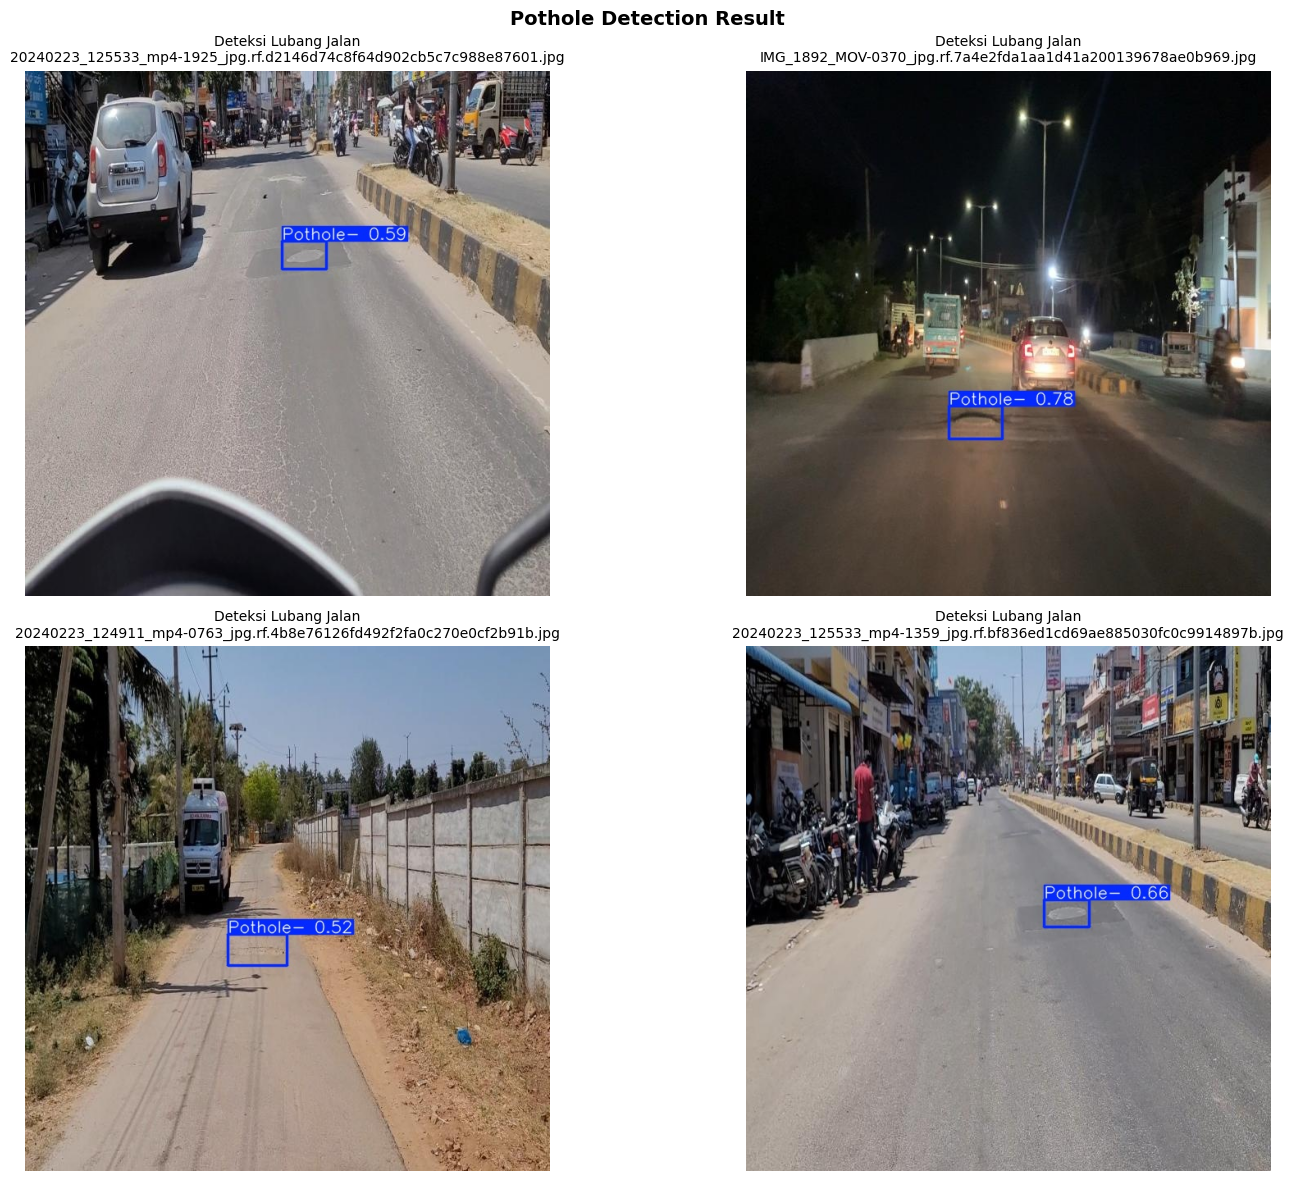

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# 1️⃣ Jalankan prediksi
pred_results = model.predict(
    source="Pothole-detection-9/test/images",
    conf=0.25,
    save=True,
    project="pothole_exp",
    name="yolov11s_combo1",
    show=False
)

# 2️⃣ Path hasil prediksi (folder output YOLO)
output_dir = "pothole_exp/yolov11s_combo1"  # sesuaikan dengan hasilmu
print(f"📁 Folder hasil deteksi: {output_dir}")

# 3️⃣ Cek file hasil deteksi
print("Contoh file hasil:", os.listdir(output_dir)[:5])

# 4️⃣ Pilih gambar hasil untuk divisualisasikan
sample_images = [
    "20240223_125533_mp4-1925_jpg.rf.d2146d74c8f64d902cb5c7c988e87601.jpg",
    "IMG_1892_MOV-0370_jpg.rf.7a4e2fda1aa1d41a200139678ae0b969.jpg",
    "20240223_124911_mp4-0763_jpg.rf.4b8e76126fd492f2fa0c270e0cf2b91b.jpg",
    "20240223_125533_mp4-1359_jpg.rf.bf836ed1cd69ae885030fc0c9914897b.jpg",
]

# 5️⃣ Visualisasikan
plt.figure(figsize=(16, 12))
for i, img_file in enumerate(sample_images):
    img_path = os.path.join(output_dir, img_file)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Deteksi Lubang Jalan\n{img_file}", fontsize=10)
    else:
        print(f"⚠️ Gambar {img_file} tidak ditemukan di {output_dir}")

plt.suptitle("Pothole Detection Result", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


# Save Model YOLOv11s Architecture
Bagian ini menjelaskan proses penyimpanan model YOLOv11s beserta arsitektur dan bobot (weights) terbaik yang diperoleh setelah proses pelatihan dan tuning. Model yang disimpan ini digunakan untuk evaluasi lanjutan, inferensi, serta reproduksi eksperimen, sehingga memastikan keberlanjutan dan konsistensi hasil penelitian.

In [ ]:
from google.colab import files
files.download("pothole_exp/yolov11s_baseline2/weights/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Error Analysis
Bagian ini membahas kasus kegagalan deteksi (error cases) yang dihasilkan oleh model YOLOv11s, seperti false positive dan false negative. Analisis dilakukan untuk mengidentifikasi faktor penyebab kesalahan, termasuk kondisi pencahayaan rendah, permukaan jalan yang kompleks, bayangan, serta lubang jalan yang tertutup air. Hasil analisis ini digunakan untuk memahami keterbatasan model dan menjadi dasar dalam perumusan arah pengembangan di masa mendatang.

In [ ]:
from ultralytics import YOLO
import shutil

In [ ]:
import os
from ultralytics.utils import ops
from ultralytics.utils.plotting import Annotator
import cv2

# Path model & dataset
model = YOLO("yolo11/baseline-best.pt")
img_dir = "Pothole-detection-9/test/images"
output_dir = "error_analysis/false_samples2"
os.makedirs(output_dir, exist_ok=True)

# Jalankan inferensi
for img_path in os.listdir(img_dir):
    if not img_path.endswith(".jpg"):
        continue
    img_full = os.path.join(img_dir, img_path)
    result = model(img_full, conf=0.25, verbose=False)[0]

    # Ambil prediksi
    boxes = result.boxes.xyxy.cpu().numpy()
    confs = result.boxes.conf.cpu().numpy()

    # Tandai kesalahan (contoh: prediksi dengan conf < 0.4 dianggap “kurang pasti”)
    if len(boxes) == 0 or (confs.mean() < 0.4):
        img = cv2.imread(img_full)
        ann = Annotator(img)
        ann.text((20, 40), "❌ Possible Miss/False Detection", txt_color=(0, 0, 255))
        cv2.imwrite(os.path.join(output_dir, img_path), ann.result())


In [ ]:
import os
import cv2
import numpy as np

# Folder paths
img_dir = "Pothole-detection-9/test/images"
gt_dir = "Pothole-detection-9/test/labels"  # ground truth labels
pred_dir = "runs/detect/error_analysis/false_samples/labels"  # predicted labels
output_dir = "error_analysis/comparison_vis"
os.makedirs(output_dir, exist_ok=True)

# Fungsi untuk membaca file YOLO format
def read_yolo_label(path, img_w, img_h):
    boxes = []
    if not os.path.exists(path):
        return boxes
    with open(path, "r") as f:
        for line in f:
            data = line.strip().split()
            if len(data) >= 5:
                cls, x, y, w, h = map(float, data[:5])
                x1 = int((x - w / 2) * img_w)
                y1 = int((y - h / 2) * img_h)
                x2 = int((x + w / 2) * img_w)
                y2 = int((y + h / 2) * img_h)
                boxes.append((x1, y1, x2, y2))
    return boxes

# Loop setiap gambar
for img_name in os.listdir(img_dir):
    if not img_name.endswith(".jpg"):
        continue

    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path)
    h, w, _ = img.shape

    # Ambil box ground truth & prediksi
    gt_boxes = read_yolo_label(os.path.join(gt_dir, img_name.replace(".jpg", ".txt")), w, h)
    pred_boxes = read_yolo_label(os.path.join(pred_dir, img_name.replace(".jpg", ".txt")), w, h)

    # Gambar bounding box
    vis = img.copy()
    for (x1, y1, x2, y2) in gt_boxes:
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 🟩 ground truth
    for (x1, y1, x2, y2) in pred_boxes:
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 🟥 prediction

    # Tambahkan label
    cv2.putText(vis, "Green: Ground Truth | Red: Prediction", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Simpan hasil visualisasi
    out_path = os.path.join(output_dir, img_name)
    cv2.imwrite(out_path, vis)

print(f"✅ Done! Visual comparison saved to {output_dir}")


✅ Done! Visual comparison saved to error_analysis/comparison_vis


In [ ]:
# ============================================================
# 1️⃣ IMPORT & SETUP
# ============================================================
from ultralytics import YOLO
import cv2
import os

# Path model & dataset
MODEL_PATH = "Yolov11-Model/best-y11.pt"   # ubah sesuai punya kamu
DATASET_PATH = "Pothole-detection-9/test/images"
GT_LABEL_PATH = "Pothole-detection-9/test/labels"

# Folder hasil prediksi dan visualisasi
PREDICT_DIR = "runs/detect/y11_pred"
OUTPUT_DIR = "comparison_overlay"

os.makedirs(PREDICT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================
# 2️⃣ PREDIKSI MENGGUNAKAN MODEL
# ============================================================
model = YOLO(MODEL_PATH)

# Jalankan inferensi di test set
results = model.predict(
    source=DATASET_PATH,   # folder test images
    conf=0.25,             # confidence threshold
    save=True,             # simpan hasil deteksi (gambar)
    save_txt=True,         # simpan prediksi ke file .txt
    project="runs/detect", # folder utama hasil prediksi
    name="y11_pred",       # subfolder prediksi
    exist_ok=True          # overwrite jika sudah ada
)

print("✅ Prediksi selesai, hasil disimpan di:", PREDICT_DIR)

# ============================================================
# 3️⃣ VISUALISASI GROUND TRUTH vs PREDIKSI
# ============================================================

def read_yolo_labels(label_path, img_w, img_h):
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                _, x, y, w, h = map(float, parts[:5])
                x1 = int((x - w / 2) * img_w)
                y1 = int((y - h / 2) * img_h)
                x2 = int((x + w / 2) * img_w)
                y2 = int((y + h / 2) * img_h)
                boxes.append((x1, y1, x2, y2))
    return boxes


IMG_DIR = DATASET_PATH
PRED_LABEL_DIR = os.path.join(PREDICT_DIR, "labels")

for img_name in os.listdir(IMG_DIR):
    if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w, _ = img.shape

    gt_boxes = read_yolo_labels(os.path.join(GT_LABEL_PATH, img_name.replace(".jpg", ".txt")), w, h)
    pred_boxes = read_yolo_labels(os.path.join(PRED_LABEL_DIR, img_name.replace(".jpg", ".txt")), w, h)

    vis = img.copy()

    # Kotak Ground Truth (hijau)
    for (x1, y1, x2, y2) in gt_boxes:
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(vis, "GT", (x1, max(y1 - 5, 15)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Kotak Prediksi (merah)
    for (x1, y1, x2, y2) in pred_boxes:
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(vis, "Pred", (x1, max(y1 - 25, 15)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Label keterangan
    cv2.putText(vis, "Green: Ground Truth | Red: Prediction", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    # Simpan hasil overlay
    cv2.imwrite(os.path.join(OUTPUT_DIR, img_name), vis)

print(f"✅ Visualisasi selesai! Gambar hasil overlay disimpan di folder: '{OUTPUT_DIR}'")



image 1/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0000_jpg.rf.e62dd31f0fa7f17d98426589e78d9d92.jpg: 640x640 2 Pothole-s, 18.5ms
image 2/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0001_jpg.rf.25a333b82f7b18d7d42953d2d9e04b80.jpg: 640x640 2 Pothole-s, 39.7ms
image 3/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0003_jpg.rf.6948adc40197af0e4ae03d10aad4b992.jpg: 640x640 2 Pothole-s, 15.6ms
image 4/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0004_jpg.rf.d57477de1c6b8150d72d22531e689c17.jpg: 640x640 2 Pothole-s, 16.9ms
image 5/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0005_jpg.rf.adaad5c209173bf0ca57d27f25b7ef85.jpg: 640x640 2 Pothole-s, 22.9ms
image 6/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0006_jpg.rf.9e269f329a3bc09957f528ec436e7167.jpg: 640x640 1 Pothole-, 15.6ms
image 7/533 /content/Pothole-detection-9/test/images/20240220_062158_mp4-0007_jpg.rf.4c587034d

In [ ]:
import os
import cv2

# Path folder (samakan dengan script sebelumnya)
IMG_DIR = "Pothole-detection-9/test/images"
GT_DIR = "Pothole-detection-9/test/labels"
PRED_DIR = "runs/detect/y11_pred/labels"

# Output folder
FN_DIR = "error_analysis/false_negative"
FP_DIR = "error_analysis/false_positive"
os.makedirs(FN_DIR, exist_ok=True)
os.makedirs(FP_DIR, exist_ok=True)

def read_yolo_labels(label_path, img_w, img_h):
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                _, x, y, w, h = map(float, parts[:5])
                x1 = int((x - w / 2) * img_w)
                y1 = int((y - h / 2) * img_h)
                x2 = int((x + w / 2) * img_w)
                y2 = int((y + h / 2) * img_h)
                boxes.append((x1, y1, x2, y2))
    return boxes

for img_name in os.listdir(IMG_DIR):
    if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w, _ = img.shape

    gt_boxes = read_yolo_labels(os.path.join(GT_DIR, img_name.replace(".jpg", ".txt")), w, h)
    pred_boxes = read_yolo_labels(os.path.join(PRED_DIR, img_name.replace(".jpg", ".txt")), w, h)

    # Kondisi error:
    # False Negative → ada GT, tapi tidak ada prediksi
    if len(gt_boxes) > 0 and len(pred_boxes) == 0:
        for (x1, y1, x2, y2) in gt_boxes:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, "❌ Miss Detection (False Negative)", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.imwrite(os.path.join(FN_DIR, img_name), img)

    # False Positive → tidak ada GT, tapi ada prediksi
    elif len(gt_boxes) == 0 and len(pred_boxes) > 0:
        for (x1, y1, x2, y2) in pred_boxes:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(img, "⚠️ False Positive", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        cv2.imwrite(os.path.join(FP_DIR, img_name), img)

print("✅ Filtering selesai!")
print(f"False Negative saved to: {FN_DIR}")
print(f"False Positive saved to: {FP_DIR}")


✅ Filtering selesai!
False Negative saved to: error_analysis/false_negative
False Positive saved to: error_analysis/false_positive


In [ ]:
from ultralytics import YOLO
model = YOLO("yolo11/best-y11.pt")

# Jalankan evaluasi di test set
results = model.val(
    data="Pothole-detection-9/data.yaml",  # file konfigurasi dataset kamu
    split="test",                           # gunakan split test
    save_json=True,                         # simpan hasil COCO-style json
    save_hybrid=True,                       # simpan prediksi+GT
    conf=0.25                               # threshold deteksi
)

print("✅ Evaluation done! Results saved at:", results.save_dir)


WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1846.9±549.1 MB/s, size: 40.1 KB)
val: Scanning /content/Pothole-detection-9/test/labels.cache... 533 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 533/533 1.0Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 12, len(boxes) = 641. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 3.9it/s 8.6s
                   all        533        641      0.809      0.665      0.761      0.397
Speed: 1.4ms preprocess, 9.9ms inference, 0.0m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil

# Ganti path sesuai lokasi Drive-mu
drive_path = "/content/drive/MyDrive/YOLOv11/comparison_overlay"

# Salin seluruh folder hasil overlay
shutil.copytree("comparison_overlay", drive_path)


'/content/drive/MyDrive/YOLOv11/comparison_overlay'